# Sidewalk

In this notebook, we will be creating a sidewalk environment in which pedestrians can walk along the sidewalk and cross the street as cars pass.

In [1]:
using Parameters
using AutomotiveDrivingModels
using AutoViz
using Revise
using Interact
using Plots

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/a40f9af00949b186b51eba526c3599ba7a53bd13-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/a40f9af00949b186b51eba526c3599ba7a53bd13-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
# Define sidewalk IDs
const TOP = 1
const BOTTOM = 2

2

### Creating the Environment
Here, we create a new type of environment called SidewalkEnv. It consists of a roadway, crosswalk, and sidewalk. A sidewalk is a Vector of Lanes that run alongside the road.

In [3]:
@with_kw mutable struct SidewalkEnv
    roadway::Roadway
    crosswalk::Lane
    sidewalk::Vector{Lane}
end

SidewalkEnv

#### Defining the Sidewalk
We define the sidewalk's parameters.

In [4]:
# Geometry parameters
roadway_length = 100.
crosswalk_length = 15.
crosswalk_width = 6.0
crosswalk_pos = roadway_length/2
sidewalk_width = 3.0
sidewalk_pos = crosswalk_length/2 - sidewalk_width / 2

6.0

Now we create the sidewalk environment. 
Our environment will consist of:
* 1-way road with 2 lanes
* Unsignalized zebra crosswalk perpendicular to the road
* Sidewalks above and below the road

In [5]:
# Generate straight roadway of length roadway_length with 2 lanes.
# Returns a Roadway type (Array of segments).
# There is already a method to generate a simple straight roadway, which we use here.
roadway = gen_straight_roadway(2, roadway_length) 

# Generate the crosswalk.
# Our crosswalk does not have a predefined method for generation, so we define it with a LaneTag and a curve.
n_samples = 2 # for curve generation
crosswalk = Lane(LaneTag(2,1), gen_straight_curve(VecE2(crosswalk_pos, -crosswalk_length/2),
                                                  VecE2(crosswalk_pos, crosswalk_length/2),
                                                   n_samples), width = crosswalk_width)
cw_segment = RoadSegment(2, [crosswalk])
push!(roadway.segments, cw_segment) # Append the crosswalk to the roadway

# Generate the sidewalk.
top_sidewalk = Lane(LaneTag(3, TOP), gen_straight_curve(VecE2(0., sidewalk_pos),
                                                      VecE2(roadway_length, sidewalk_pos),
                                                        n_samples), width = sidewalk_width)
bottom_sidewalk = Lane(LaneTag(3, BOTTOM), gen_straight_curve(VecE2(0., -(sidewalk_pos - sidewalk_width)),
                                                          VecE2(roadway_length, -(sidewalk_pos - sidewalk_width)),
                                                            n_samples), width = sidewalk_width) 
    # Note: we subtract the sidewalk_width from the sidewalk position so that the edge is flush with the road.


sw_segment = RoadSegment(3, [top_sidewalk, bottom_sidewalk])
push!(roadway.segments, sw_segment)

# Initialize crosswalk environment
env = SidewalkEnv(roadway, crosswalk, [top_sidewalk, bottom_sidewalk]);

Since there is no defined render! method for the crosswalk and the sidewalk, we must define it ourselves.

In [6]:
function AutoViz.render!(rendermodel::RenderModel, env::SidewalkEnv)
    # Render sidewalk
    for sw in env.sidewalk
        curve = sw.curve
        n = length(curve)
        pts = Array{Float64}(2, n)
        for (i,pt) in enumerate(curve)
            pts[1,i] = pt.pos.x
            pts[2,i] = pt.pos.y
        end
        add_instruction!(rendermodel, render_line, (pts, colorant"grey", sw.width, Cairo.CAIRO_LINE_CAP_BUTT))
    end
    
    # Render roadway
    roadway = gen_straight_roadway(2, roadway_length)
    render!(rendermodel, roadway)
    
    # Render crosswalk
    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array{Float64}(2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    # We can add render instructions from AutoViz.
    # Here we want the crosswalk to appear as a white-striped zebra crossing rather than a road.
    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, Cairo.CAIRO_LINE_CAP_BUTT))

    return rendermodel
end

In [7]:
cam = FitToContentCamera(0.0)
render(Scene(), env, cam = cam);

Now we can define our pedestrian.

In [8]:
# We define its class and the dimensions of its bounding box.
const PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

VehicleDef(PEDESTRIAN, 1.000, 1.000)

We assign models to each agent in the scene.

In [9]:
timestep = 0.1

# Crossing pedestrian definition
ped_init_state = VehicleState(VecSE2(49.0,-3.0,0.), env.sidewalk[BOTTOM], roadway, 1.3)
ped = Vehicle(ped_init_state, PEDESTRIAN_DEF, 1)

# Car definition
car_initial_state = VehicleState(VecSE2(0.0, 0., 0.), roadway.segments[1].lanes[1],roadway, 8.0)
car = Vehicle(car_initial_state, VehicleDef(), 2)

scene = Scene()
push!(scene, ped)
push!(scene, car)

# Define a model for each entity present in the scene
models = Dict{Int, DriverModel}()

ped_id = 1
car_id = 2

models[ped_id] = SidewalkPedestrianModel(timestep=timestep, 
                                            crosswalk=env.crosswalk,
                                            sw_origin = env.sidewalk[BOTTOM],
                                            sw_dest = env.sidewalk[TOP]
                                            )

models[car_id] = 
LatLonSeparableDriver( # produces LatLonAccels
        ProportionalLaneTracker(), # lateral model
        IntelligentDriverModel(), # longitudinal model
)

AutomotiveDrivingModels.LatLonSeparableDriver(AutomotiveDrivingModels.ProportionalLaneTracker(NaN, NaN, 3.0, 2.0), AutomotiveDrivingModels.IntelligentDriverModel
  a: Float64 NaN
  σ: Float64 NaN
  k_spd: Float64 1.0
  δ: Float64 4.0
  T: Float64 1.5
  v_des: Float64 29.0
  s_min: Float64 5.0
  a_max: Float64 3.0
  d_cmf: Float64 2.0
  d_max: Float64 9.0
)

### Simulate
Finally, we simulate the scene.

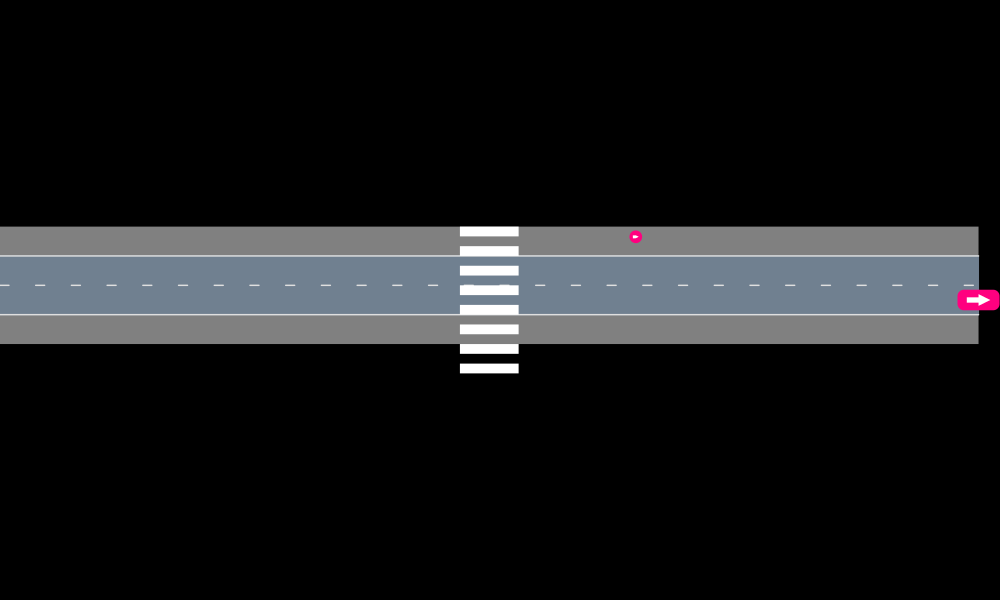

In [10]:
nticks = 300
rec = SceneRecord(nticks+1, timestep)
# Execute the simulation
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], env, cam=cam)

We can use a slider to scroll through each frame in the simulation. This usually takes less time than rendering a video.

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_02", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-3b9a8604-bbd7-4d07-836d-2de061c351d4", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Any,Any}(Pair{Any,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Any,Any}(Pair{Any,Any}(:max, 301),Pair{Any,Any}(:style, Dict{Any,Any}()),Pair{Any,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Any,Any}(:step, 1),Pair{Any,Any}(:className, "slider slider is-fullwidth"),Pair{Any,Any}(:min, 1)), 0)], Dict{Any,Any}(Pair{Any,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Any,Any}(Pair{Any,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Any,Any}(Pair{Any,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_01", 151, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/Users/samanthakim/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/Users/samanthakim/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/Users/samanthakim/.julia/v0.6/InteractBase/src/../assets/all.js", "/Users/samanthakim/.julia/v0.6/InteractBase/src/../assets/style.css", "/Users/samanthakim/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":151}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {return this.value
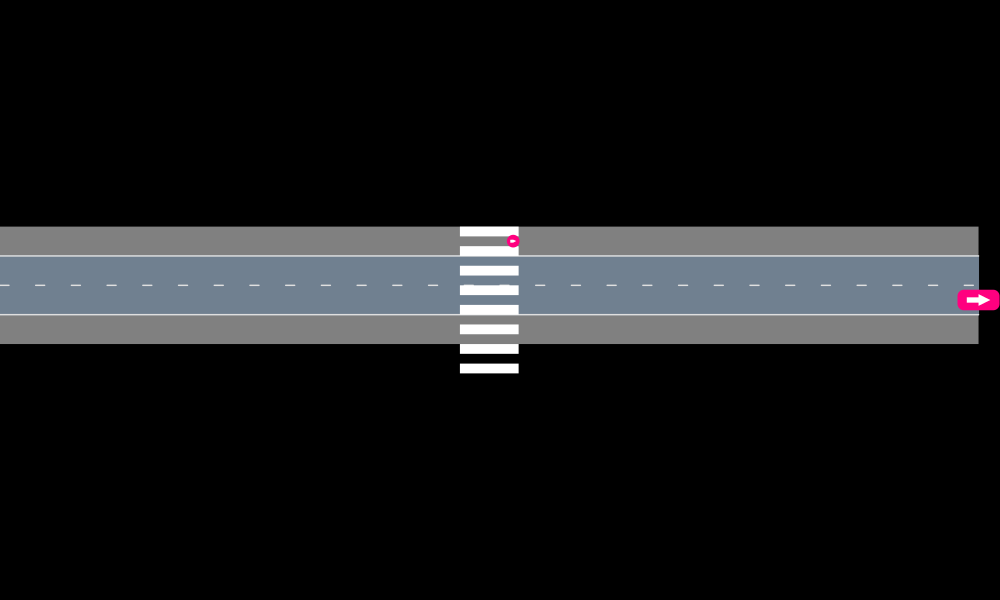
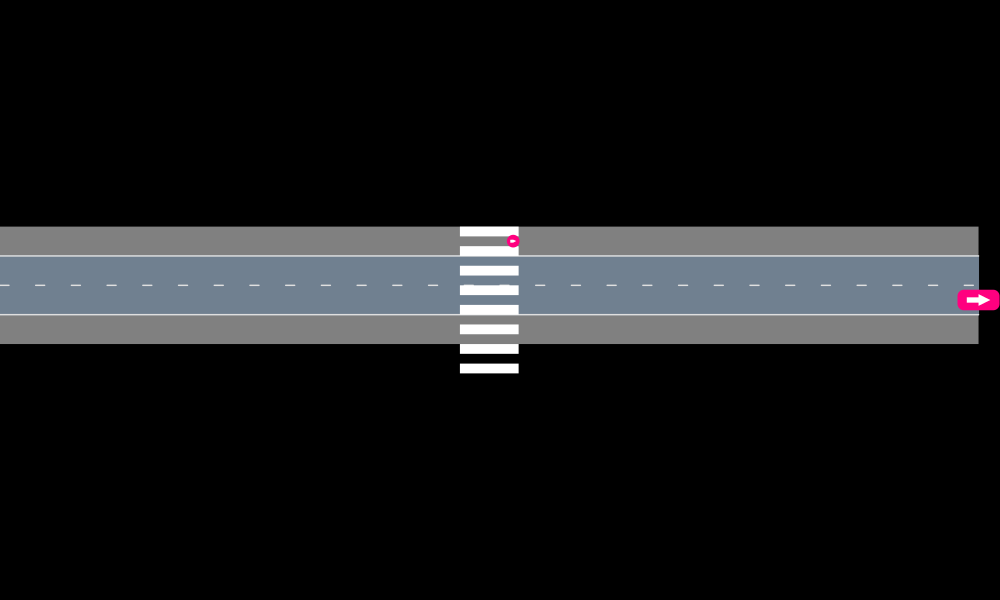

In [11]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], env, cam=cam)
end